Installation and importation libraries

In [1]:
!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading the CSV, Analysing the rows and columns of the dataset

In [2]:
df = pd.read_csv('yuma_energy_raw_data.csv')
df.describe()

,TransactionID,CustomerID,ProductID,Quantity,PricePerUnit,TotalAmount,TrustPointsUsed,DiscountApplied
count,50.000000,45.000000,50.000000,50.000000,36.000000,36.000000,50.000000,45.000000
mean,25.460000,1002.444444,2004.920000,1.420000,125.277778,155.277778,28.800000,23.888889
std,14.640188,1.306549,2.284285,1.263135,188.292874,351.596247,39.467889,13.853490
min,1.000000,1001.000000,2001.000000,-1.000000,10.000000,-500.000000,-10.000000,5.000000
25%,13.250000,1001.000000,2003.000000,1.000000,17.500000,10.000000,0.000000,15.000000
50%,25.500000,1002.000000,2005.000000,1.000000,30.000000,40.000000,20.000000,20.000000
75%,37.750000,1003.000000,2007.000000,2.000000,100.000000,150.000000,50.000000,30.000000
max,50.000000,1005.000000,2008.000000,5.000000,500.000000,1500.000000,100.000000,50.000000


In [3]:
df.columns

Index(['TransactionID', 'CustomerID', 'TransactionDate', 'ProductID',
       'ProductCategory', 'Quantity', 'PricePerUnit', 'TotalAmount',
       'TrustPointsUsed', 'PaymentMethod', 'DiscountApplied'],
      dtype='object')

In [4]:
df.shape

(50, 11)

DATA PRE-PROCESSING

Step-1: Drop the duplicate rows and the rows with order quantity = 0

In [5]:
df.drop_duplicates(subset=['TransactionID'], inplace=True)
df = df[df['Quantity']!=0]

In [6]:
df.shape

(45, 11)

Step-2: For rows with negative order qunatity, update them with the absolute order quantity

In [7]:
df.loc[df['Quantity'] < 0, 'Quantity'] *= -1

Step-3: Replacing the missing customerID and transaction date with the most frequent(mode) values.

In [8]:
mode_customerID = df['CustomerID'].mode()[0]
mode_transactionDate = df['TransactionDate'].mode()[0]
df['CustomerID'].fillna(mode_customerID, inplace=True)
df['TransactionDate'].fillna(mode_transactionDate, inplace=True)

C:\Users\Ankit Kishan\AppData\Local\Temp\ipykernel_23716\3661040562.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CustomerID'].fillna(mode_customerID, inplace=True)
C:\Users\Ankit Kishan\AppData\Local\Temp\ipykernel_23716\3661040562.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

Step-4: Ensuring each productID has unique ProductCategory

In [9]:
inconsistent_ids = df.groupby('ProductID')['ProductCategory'].nunique()
inconsistent_ids = inconsistent_ids[inconsistent_ids > 1].index
def resolve_inconsistency(group):
    most_frequent_category = group['ProductCategory'].mode()[0]
    group['ProductCategory'] = most_frequent_category
    return group

df_corrected = df.groupby('ProductID').apply(resolve_inconsistency)
df = df_corrected.reset_index(drop=True)

C:\Users\Ankit Kishan\AppData\Local\Temp\ipykernel_23716\1870496319.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_corrected = df.groupby('ProductID').apply(resolve_inconsistency)


Step-5: Ensure the price per unit of each productID is consistent

In [10]:
price_stats = df.groupby('ProductID')['PricePerUnit'].agg(['mean', 'min', 'max']).reset_index()
mode_df = df.groupby('ProductID')['PricePerUnit'].agg(lambda x: x.mode()[0]).reset_index()
mode_df.rename(columns={'PricePerUnit': 'mode'}, inplace=True)
price_stats = pd.merge(price_stats, mode_df, on='ProductID')
price_stats

,ProductID,mean,min,max,mode
0,2001,40.000000,30.0,50.0,30.0
1,2002,262.500000,20.0,500.0,500.0
2,2003,42.000000,10.0,100.0,10.0
3,2004,16.666667,10.0,30.0,10.0
4,2005,500.000000,500.0,500.0,500.0
5,2006,42.000000,10.0,50.0,50.0
6,2007,88.750000,10.0,500.0,10.0
7,2008,55.000000,10.0,100.0,10.0


In [11]:
threshold = 0.8
price_stats['range'] = price_stats['max'] - price_stats['min']
price_stats['FinalPricePerUnit'] = np.where(price_stats['range'] * threshold <= price_stats['mean'], price_stats['mean'], price_stats['mode'])
df = df.merge(price_stats[['ProductID', 'FinalPricePerUnit']], on='ProductID', how='left')
df['PricePerUnit'] = df['FinalPricePerUnit']
df['PricePerUnit'] = df['PricePerUnit'].round(1)
df = df.drop(columns=['FinalPricePerUnit'])
df['TotalAmount'] = df['PricePerUnit']*df['Quantity']
df

,TransactionID,CustomerID,TransactionDate,ProductID,ProductCategory,Quantity,PricePerUnit,TotalAmount,TrustPointsUsed,PaymentMethod,DiscountApplied
0,17,1002.0,09/08/24 15:00,2001,Electronics,1,40.0,40.0,20,NaN,10.0
1,23,1002.0,10/08/24 0:00,2001,Electronics,1,40.0,40.0,0,Cash,5.0
2,31,1004.0,04/08/24 16:00,2001,Electronics,3,40.0,120.0,0,Credit Card,30.0
3,42,1003.0,07/08/24 18:00,2001,Electronics,3,40.0,120.0,100,Cash,NaN
4,3,1004.0,02/08/24 19:00,2002,Electronics,3,500.0,1500.0,0,Credit Card,25.0
5,25,1003.0,06/08/24 3:00,2002,Electronics,1,500.0,500.0,50,Cash,50.0
6,34,1001.0,04/08/24 15:00,2002,Electronics,1,500.0,500.0,-10,Credit Card,10.0
7,35,1001.0,06/08/24 8:00,2002,Electronics,1,500.0,500.0,100,Trust Points,30.0
8,11,1001.0,09/08/24 7:00,2003,Toys,5,10.0,50.0,-10,Credit Card,20.0
9,15,1001.0,02/08/24 15:00,2003,Toys,1,10.0,10.0,-10,Cash,20.0


Step-6: cleaning the TrustPointsUsed Column by addressing the negative values and making the PaymentMethod null for the rows with TrustPointsUsed = 0 and PaymentMethod = Trust Points

In [12]:
df['TrustPointsUsed'] = df['TrustPointsUsed'].apply(lambda x: max(x, 0))
df.loc[(df['TrustPointsUsed'] == 0) & (df['PaymentMethod'] == 'Trust Points'), 'PaymentMethod'] = np.nan

Step-7: Cleaning up the payment method column and discount applied columns

In [13]:
mode_df = df.groupby('CustomerID')['PaymentMethod'].agg(lambda x: x.mode().tolist()).reset_index()
mode_df.rename(columns={'PaymentMethod': 'mode_list'}, inplace=True)

# Extract the mode and second mode if available
mode_df['mode'] = mode_df['mode_list'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
mode_df['second_mode'] = mode_df['mode_list'].apply(lambda x: x[1] if len(x) > 1 else np.nan)

# Merge the mode information back into the original DataFrame
df = df.merge(mode_df[['CustomerID', 'mode', 'second_mode']], on='CustomerID', how='left')

# Step 2: Define a function to replace missing PaymentMethod
def replace_payment_method(row):
    if pd.isna(row['PaymentMethod']):
        if row['TrustPointsUsed'] == 0:
            # Use the mode or second mode based on conditions
            return row['mode'] if row['PaymentMethod'] != 'Trust Points' else row['second_mode']
        else:
            return row['mode']
    return row['PaymentMethod']

df['PaymentMethod'] = df.apply(replace_payment_method, axis=1)
df.drop(columns=['mode', 'second_mode'], inplace=True)
df['DiscountApplied'] = np.where(df['DiscountApplied'] > df['PricePerUnit']*df['Quantity'], 0, df['DiscountApplied'])
df['DiscountApplied'].fillna(0, inplace=True)
df

C:\Users\Ankit Kishan\AppData\Local\Temp\ipykernel_23716\3718837852.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DiscountApplied'].fillna(0, inplace=True)


,TransactionID,CustomerID,TransactionDate,ProductID,ProductCategory,Quantity,PricePerUnit,TotalAmount,TrustPointsUsed,PaymentMethod,DiscountApplied
0,17,1002.0,09/08/24 15:00,2001,Electronics,1,40.0,40.0,20,Cash,10.0
1,23,1002.0,10/08/24 0:00,2001,Electronics,1,40.0,40.0,0,Cash,5.0
2,31,1004.0,04/08/24 16:00,2001,Electronics,3,40.0,120.0,0,Credit Card,30.0
3,42,1003.0,07/08/24 18:00,2001,Electronics,3,40.0,120.0,100,Cash,0.0
4,3,1004.0,02/08/24 19:00,2002,Electronics,3,500.0,1500.0,0,Credit Card,25.0
5,25,1003.0,06/08/24 3:00,2002,Electronics,1,500.0,500.0,50,Cash,50.0
6,34,1001.0,04/08/24 15:00,2002,Electronics,1,500.0,500.0,0,Credit Card,10.0
7,35,1001.0,06/08/24 8:00,2002,Electronics,1,500.0,500.0,100,Trust Points,30.0
8,11,1001.0,09/08/24 7:00,2003,Toys,5,10.0,50.0,0,Credit Card,20.0
9,15,1001.0,02/08/24 15:00,2003,Toys,1,10.0,10.0,0,Cash,0.0


VISUALISATION

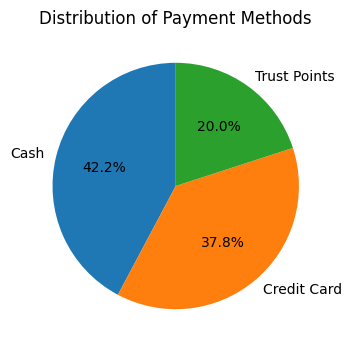

In [19]:
payment_counts = df['PaymentMethod'].value_counts()
plt.figure(figsize=(4, 4))
payment_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Payment Methods')
plt.ylabel('')
plt.show()

C:\Users\Ankit Kishan\AppData\Local\Temp\ipykernel_23716\1160476833.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate']).dt.date


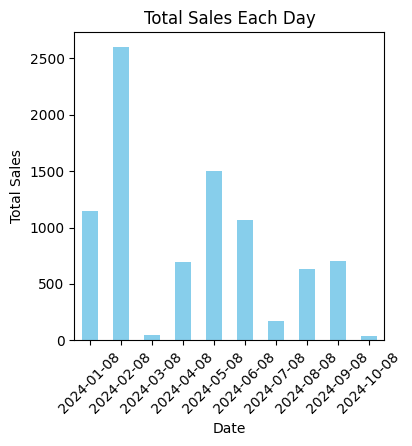

In [20]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate']).dt.date
daily_sales = df.groupby(df['TransactionDate'])['TotalAmount'].sum()
plt.figure(figsize=(4, 4))
daily_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales Each Day')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

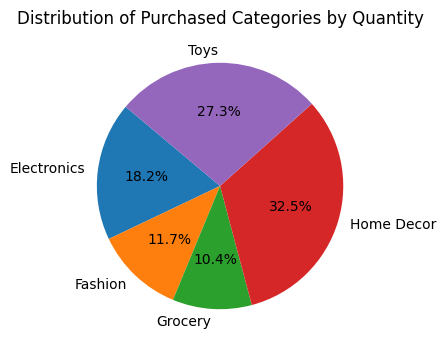

In [16]:
category_distribution = df.groupby('ProductCategory')['Quantity'].sum()
plt.figure(figsize=(4, 4))
category_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Purchased Categories by Quantity')
plt.ylabel('')  # Remove the y-label
plt.show()

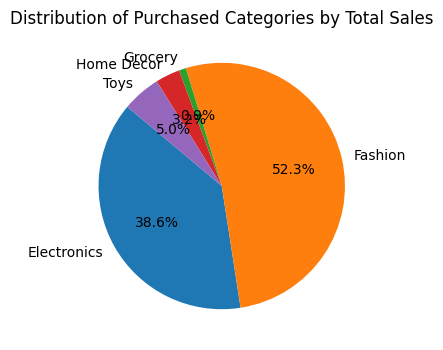

In [17]:
category_distribution = df.groupby('ProductCategory')['TotalAmount'].sum()
plt.figure(figsize=(4, 4))
category_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Purchased Categories by Total Sales')
plt.ylabel('')
plt.show()

Data Verification

       TransactionID   CustomerID    ProductID   Quantity  PricePerUnit  \
count      45.000000    45.000000    45.000000  45.000000     45.000000   
mean       24.844444  1002.311111  2005.000000   1.711111    114.817778   
std        14.218994     1.345400     2.266355   0.991377    195.133699   
min         1.000000  1001.000000  2001.000000   1.000000     10.000000   
25%        13.000000  1001.000000  2003.000000   1.000000     10.000000   
50%        25.000000  1002.000000  2005.000000   1.000000     10.000000   
75%        36.000000  1003.000000  2007.000000   3.000000     42.000000   
max        50.000000  1005.000000  2008.000000   5.000000    500.000000   

       TotalAmount  TrustPointsUsed  DiscountApplied  
count    45.000000        45.000000        45.000000  
mean    191.351111        28.000000        14.333333  
std     374.440838        37.331439        14.984841  
min      10.000000         0.000000         0.000000  
25%      10.000000         0.000000         0.000

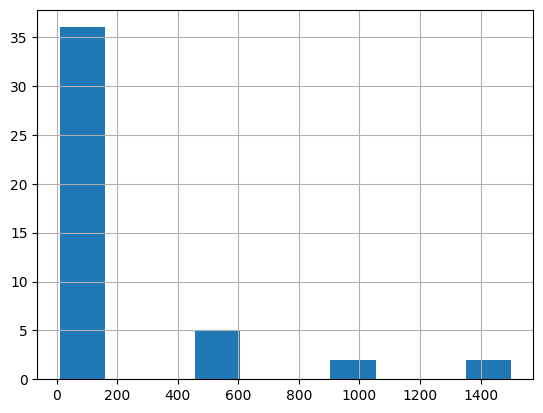

In [18]:
# Descriptive Statistics
print(df.describe())

# Missing Values
print(df.isnull().sum())

# Sample Data Inspection
print(df.head())

# Histogram of Total Amount
df['TotalAmount'].hist()
plt.show()